## Assignment 1

**Submission deadlines:** 
- get at least **2** points by Tuesday, 9.03.2021
- remaining points: last lab session before or on Tuesday, 16.03.2021

**Points:** Aim to get 8 out of 12 possible points

## Submission instructions
The class is held remotely. To sumbmit your solutions please show the notebook over the video call. Make sure you know all the questions and asnwers, and that the notebook contains results (before presentation do `Runtime -> Restar and run all`)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Task description

## TLDR
Implement and train a neural network using pure numpy.


## Problem 1 [2p]
Implement a two-layer network, manually set weights and biases to solve the XOR task.

A two-layer neural network implementes a function $f: \mathbb{R}^D \rightarrow \mathbb{R}^O$ where $D$ is the input dimensionality and $O$ is the output dinemsionality. The output goes through an intermediate representation (the hidden layer) with dimensionality $H$. 

The computations are as follows:
\begin{equation}
\begin{split}
A_1 &= x W_1^T + b_1  & \qquad\text{Total input to neurons in the hidden layer (network's first layer)} \\
O_1 &= \sigma_1(A_1)  & \qquad\text{Output of the hidden layer} \\
A_2 &= O_1 W_2^T + b_2 & \qquad\text{Total input to neurons in the output layer (network's second layer)}\\
O_2 &= \sigma_2(A_2) & \qquad\text{Output of the network}
\end{split}
\end{equation}

Where $W$ are weight matrices, $b$ are bias vectors, $\sigma$ are non-linear activation functions (e.g. the logistic sigmoid applied element-wise, or softmax).

For the 2D xor problem the network will:
- have 2 inputs, 2 hidden neurons, one output
- use the logistic sigmoid everywhere (that way we, when hand-designig the weights, we can assume that neurons' outputs are binary).

Therrefore the shapes of the data floing through the network will be:
- input: $x\in\mathbb{}R^{2}$
- hidden layer parameters: $W_1\in\mathbb{}R^{2\times 2}$ and $b_1\in\mathbb{}R^{2}$
- representations in the hidden layer: $A_1\in\mathbb{}R^{2}$ and $O_1\in\mathbb{}R^{2}$
- output layer parameters: $W_2\in\mathbb{}R^{1\times 2}$ and $b_1\in\mathbb{}R^{1}$
- representations in the output layer: $A_2\in\mathbb{}R^{1}$ and $O_2\in\mathbb{}R^{1}$

The network can be seen as a logistic regression model, prefixed by a nonlinear transformation of the data.

The first tasks consists of:
- implementing the network
- selecting parametwrs ($W_1, b_1, W_2, b_2$) such that $f(x)\approx XOR(x_1, x_2)$ where the approximation is die to the sigmoids - the output may be close to 0 or 1, but doesn't need to saturate at 0 or 1.

NB: the convention on weight matrix shapes follows linear [layers in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).


## Problem 2 [2p]
1. Add a backward pass.
2. Use a sensible random initialization for weights and biases.
3. Numerically check the correctness of your gradient computation.

There is nice article about taking derivative over vectors and vector chain rule: https://explained.ai/matrix-calculus/ if someone don't have experience with suchr calculus.


## Problem 3 [2p]
1. Implement gradient descent
2. Train your network to solve 3D XOR
3. Try several hidden layer sizes, for each size record the fracton of successful trainings. Then answer:
    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    - What is the minimal hidden size required to reliably solve 3D XOR
    - Which networks are easier to train - small or large ones? Why?


## Problem 4 [1p]
Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Find a network architecture which reliably learns the 3D XOR problem.


## Problem 5 [1p]
Add a second hidden layer to your network, implement the forward and backward pass, then demonstrate training.


## Problem 6 [2p]
Implement a way to have a _variable number_ of hidden layers. Check how deep sigmoid or ReLU networks you  can train. For simplicity you can assume that all hidden layers have the same number of neurons, and use the same activation function.


## Problem 7 [2p]
For each weight matrix $w\in\mathbb{R}^{n\times m}$, add a randomly initialized `backward weight` $w_b\in\mathbb{R}^{m\times n}$, which will not change during training. Change the backward pass to use $w_b$ instead of $w^T$, getting an approxmatoin of the true gradient. Can you get your network to train?

NB: this approach, dubbed [feedback alignment](https://www.nature.com/articles/ncomms13276), was proposed to make error backpropagation more biologically plausible, by providing a solution to the "weight transport problem". Regular backpropagation requires that neurons not only know their incoming weights (thet they control), but also their outgoing weights (that are controlled by neurons in the upper layers). This is nearly impossible in a real brain.

# Solutions and starter code

In [2]:
import matplotlib.pyplot as plt
import numpy as np

XOR dataset creation

(-0.05, 1.05, -0.05, 1.05)

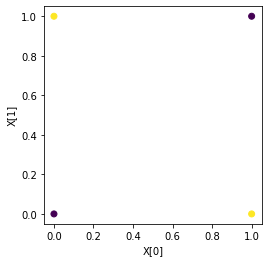

In [ ]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1],], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array([[0], [1], [1], [0],], dtype=np.float32)

plt.scatter(
    X[:, 0], X[:, 1], c=Y[:, 0],
)
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.axis("square")

## Problem 1

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D$ matrix.

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0)


class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 =  np.random.normal(0, 0.5, self.W1.shape)
        self.b1 =  np.random.normal(0, 0.5, self.b1.shape)
        self.W2 =  np.random.normal(0, 0.5, self.W2.shape)
        self.b2 =  np.random.normal(0, 0.5, self.b2.shape)

    def forward(self, X, Y=None, do_backward=False, use_relu=False):
        # TODO Problem 1: Fill in details of forward propagation
        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # print('A1', A1)
        # Outputs after the sigmoid non-linearity
        O1 = relu(A1) if use_relu else sigmoid(A1)
        # print('O1', O1)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2
        # print('A2', A2)
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)
        # print('O2', O2)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2:
            # fill in the gradient computation
            # Please note, that there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reverse order.
            # We save the gradients with respect to the parameters as fields of self.
            # It is not very elegant, but simplifies training code later on.

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient
            # of logistic sigmoid and cross-entropy loss
            samples_no = X.shape[0]
            A2_grad = O2 - Y
            self.b2_grad = A2_grad.mean(0)
            self.W2_grad = (A2_grad.T @ O1) / samples_no
            O1_grad = A2_grad @ self.W2
            A1_grad = O1_grad * (
                np.heaviside(A1, 0) if use_relu else sigmoid(A1) * (1.0 - sigmoid(A1))
            )
            self.b1_grad = A1_grad.mean(0)
            self.W1_grad = (A1_grad.T @ X) / samples_no

        return O2, loss

In [ ]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([[10, 10], [10, 10]])
net.b1 = np.array([-5, -15])
net.W2 = np.array([[10, -10]])
net.b2 = np.array([-5])

# Hint: since we use the logistic sigmoid activation, the weights may need to
# be fairly large


predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 0.0071527881888964915
XORnet([0. 1.]) = 0.9923558641717396
XORnet([1. 0.]) = 0.9923558641717396
XORnet([1. 1.]) = 0.0071527881888964785


## Problem 2

In [ ]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + "_grad")
    assert param.shape == orig_grad.shape

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [ ]:
# Hint: use float64 for checking the correctness of the gradient
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ["W1", "b1", "W2", "b2"]:
    check_grad(net, param_name, X, Y)

## Problem 3

In [ ]:
alpha = [0.01, 0.1, 1, 2, 10]  # set a learning rate
min_loss = np.inf
best_a = None

for a in alpha:
    net = SmallNet(2, 10, dtype=np.float64)
    for i in range(100000):
        _, loss = net.forward(X, Y, do_backward=True)
        # if (i % 5000) == 0:
        #     print(f"after {i} steps \tloss={loss}")
        for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(net, param_name)
            # Hint: use the construct `param[:]` to change the contents of the array!
            # Doing instead `param = new_val` simply changes to what the variable
            # param points to, without affecting the network!
            # alternatively, you could do setattr(net, param_name, new_value)
            param[:] = param - a * getattr(net, param_name + "_grad")
    print(f"for alpha {a} loss is {loss}")
    if loss <= min_loss and best_a and a > best_a:
        best_a = a
        min_loss = loss

print(f"Smallest loss is {loss} for alpha {a}")

for alpha 0.01 loss is 0.008903892446338199
for alpha 0.1 loss is 0.0004677491284820883
for alpha 1 loss is 5.558611308482275e-05
for alpha 2 loss is 1.4524060772708552e-05
for alpha 10 loss is 8.762609091830072e-06
Smallest loss is 8.762609091830072e-06 for alpha 10


In [ ]:
predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 6.075407153172187e-07
XORnet([0. 1.]) = 0.9999926458878381
XORnet([1. 0.]) = 0.9999920065099357
XORnet([1. 1.]) = 1.909469187601215e-05


In [3]:
X3 = np.array([[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 1, 1],], dtype=np.float32)
Y3 = np.array([[0], [1], [0], [1],], dtype=np.float32)

In [ ]:
# TODO:
# Generate data for a 3D XOR task
# Then estimate the success rate of training the network with diferent
# hidden sizes.
import itertools

alpha = [0.01, 0.1, 1, 2, 10]  # set a learning rate
min_loss = np.inf
best_a = None
best_hidden_dim = None

for hidden_dim, a in itertools.product([2, 3, 5, 10, 20], alpha):
    # TODO: run a few trainings and record the fraction of successful ones
    net = SmallNet(3, hidden_dim, dtype=np.float64)

    for i in range(100000):
        _, loss = net.forward(X3, Y3, do_backward=True)
        # if (i % 5000) == 0:
        #     print(f"after {i} steps \tloss={loss}")
        for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(net, param_name)
            param[:] = param - a * getattr(net, param_name + "_grad")

    print(f"For hidden_dim={hidden_dim} and alpha {a}, the loss is {loss}!")
    if loss < min_loss or (loss <= min_loss and best_a and a > best_a):
        best_a = a
        min_loss = loss
        best_hidden_dim = hidden_dim

print(f"Best loss is {min_loss} for alpha {best_a} for hidden_dim={hidden_dim}")

For hidden_dim=2 and alpha 0.01, the loss is 0.003068809958297629!
For hidden_dim=2 and alpha 0.1, the loss is 0.00034226316606232566!
For hidden_dim=2 and alpha 1, the loss is 3.36366452999664e-05!
For hidden_dim=2 and alpha 2, the loss is 1.5773077640445776e-05!
For hidden_dim=2 and alpha 10, the loss is 2.1447702327670953e-06!
For hidden_dim=3 and alpha 0.01, the loss is 0.003329102528954923!
For hidden_dim=3 and alpha 0.1, the loss is 0.00020017680833995345!
For hidden_dim=3 and alpha 1, the loss is 2.1203196844376303e-05!
For hidden_dim=3 and alpha 2, the loss is 1.6097191082788452e-05!
For hidden_dim=3 and alpha 10, the loss is 5.025297058566888e-06!
For hidden_dim=5 and alpha 0.01, the loss is 0.0023292436978141744!
For hidden_dim=5 and alpha 0.1, the loss is 0.00019428605376550526!
For hidden_dim=5 and alpha 1, the loss is 1.3788688827357093e-05!
For hidden_dim=5 and alpha 2, the loss is 7.205930177031421e-06!
For hidden_dim=5 and alpha 10, the loss is 1.9154989967190173e-06!
F

## Problem 4


In [ ]:
min_loss = np.inf
best_a = None
best_hidden_dim = None

for hidden_dim, a in itertools.product([2, 3, 5, 10, 20], alpha):
    # TODO: run a few trainings and record the fraction of successful ones
    net = SmallNet(3, hidden_dim, dtype=np.float64)

    for i in range(100000):
        _, loss = net.forward(X3, Y3, do_backward=True, use_relu=True)
        # if (i % 5000) == 0:
        #     print(f"after {i} steps \tloss={loss}")
        for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(net, param_name)
            param[:] = param - a * getattr(net, param_name + "_grad")

    print(f"For hidden_dim={hidden_dim} and alpha {a}, the loss is {loss}!")
    if loss < min_loss or (loss <= min_loss and best_a and a > best_a):
        best_a = a
        min_loss = loss
        best_hidden_dim = hidden_dim

print(f"Best loss is {min_loss} for alpha {best_a} for hidden_dim={hidden_dim}")

For hidden_dim=2 and alpha 0.01, the loss is 0.3467957741972816!
For hidden_dim=2 and alpha 0.1, the loss is 3.172625141838901e-05!
For hidden_dim=2 and alpha 1, the loss is 1.1845259408753107e-05!
For hidden_dim=2 and alpha 2, the loss is 0.6931471805599453!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


For hidden_dim=2 and alpha 10, the loss is 1.0444277593378284!
For hidden_dim=3 and alpha 0.01, the loss is 0.0013494564313930918!
For hidden_dim=3 and alpha 0.1, the loss is 1.9284005527075793e-05!
For hidden_dim=3 and alpha 1, the loss is 1.1591663880539234e-05!
For hidden_dim=3 and alpha 2, the loss is 5.853826102745409e-06!
For hidden_dim=3 and alpha 10, the loss is 1.0444277593378282!
For hidden_dim=5 and alpha 0.01, the loss is 0.0003458209945047734!
For hidden_dim=5 and alpha 0.1, the loss is 0.00012098840898664596!
For hidden_dim=5 and alpha 1, the loss is 1.5467895646233955e-06!
For hidden_dim=5 and alpha 2, the loss is 7.429731622940039e-07!
For hidden_dim=5 and alpha 10, the loss is 1.0444277593378284!
For hidden_dim=10 and alpha 0.01, the loss is 0.0002989102562927277!
For hidden_dim=10 and alpha 0.1, the loss is 2.2562055068049643e-05!
For hidden_dim=10 and alpha 1, the loss is 1.7305115288254157e-06!
For hidden_dim=10 and alpha 2, the loss is 7.795030374519402e-07!
For hi

A better architecture would learn to do XOR on pairs of inputs and then XOR their results.

## Problem 5

In [ ]:
class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((num_hidden, num_hidden), dtype=dtype)
        self.b2 = np.zeros((num_hidden,), dtype=dtype)
        self.W3 = np.zeros((1, num_hidden), dtype=dtype)
        self.b3 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 =  np.random.normal(0, 0.5, self.W1.shape)
        self.b1 =  np.random.normal(0, 0.5, self.b1.shape)
        self.W2 =  np.random.normal(0, 0.5, self.W2.shape)
        self.b2 =  np.random.normal(0, 0.5, self.b2.shape)
        self.W3 =  np.random.normal(0, 0.5, self.W3.shape)
        self.b3 =  np.random.normal(0, 0.5, self.b3.shape)

    def forward(self, X, Y=None, do_backward=False, use_relu=False):
        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # Outputs after the non-linearity
        O1 = relu(A1) if use_relu else sigmoid(A1)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2
        # Outputs after the non-linearity
        O2 = relu(A2) if use_relu else sigmoid(A2)
        # Inputs to neuron in the third layer
        A3 = O2 @ self.W3.T + self.b3
        # Outputs after the sigmoid non-linearity
        O3 = sigmoid(A3)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O3) - (1 - Y) * np.log(1.0 - O3)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            samples_no = X.shape[0]
            A3_grad = O3 - Y
            self.b3_grad = A3_grad.mean(0)
            self.W3_grad = (A3_grad.T @ O2) / samples_no

            O2_grad = A3_grad @ self.W3
            A2_grad = O2_grad * (
                np.heaviside(A2, 0) if use_relu else sigmoid(A2) * (1.0 - sigmoid(A2))
            )
            self.b2_grad = A2_grad.mean(0)
            self.W2_grad = (A2_grad.T @ O1) / samples_no

            O1_grad = A2_grad @ self.W2
            A1_grad = O1_grad * (
                np.heaviside(A1, 0) if use_relu else sigmoid(A1) * (1.0 - sigmoid(A1))
            )
            self.b1_grad = A1_grad.mean(0)
            self.W1_grad = (A1_grad.T @ X) / samples_no

        return O3, loss

In [ ]:
net = SmallNet(3, 4, dtype=np.float64)
alpha = 0.1

for i in range(100000):
    _, loss = net.forward(X3, Y3, do_backward=True, use_relu=True)
    if (i % 5000) == 0:
        print(f"after {i} steps \tloss={loss}")
    for param_name in ["W1", "b1", "W2", "b2", "W3", "b3"]:
        param = getattr(net, param_name)
        param[:] = param - alpha * getattr(net, param_name + "_grad")

after 0 steps 	loss=0.711151426843322
after 5000 steps 	loss=0.0022685550529173574
after 10000 steps 	loss=0.0010976802809354726
after 15000 steps 	loss=0.0007222773748799164
after 20000 steps 	loss=0.0005372815764357329
after 25000 steps 	loss=0.000426935457066918
after 30000 steps 	loss=0.00035418472529282277
after 35000 steps 	loss=0.0003025808827991499
after 40000 steps 	loss=0.0002640919720705084
after 45000 steps 	loss=0.00023426628150605562
after 50000 steps 	loss=0.00021048776243334165
after 55000 steps 	loss=0.00019107927975434792
after 60000 steps 	loss=0.00017493764443483471
after 65000 steps 	loss=0.00016130631899374855
after 70000 steps 	loss=0.00014964515810182954
after 75000 steps 	loss=0.00013955173112588728
after 80000 steps 	loss=0.00013073259728265676
after 85000 steps 	loss=0.00012295800151953498
after 90000 steps 	loss=0.00011605523085252634
after 95000 steps 	loss=0.00010988530449062802


## Problem 6

In [5]:
class NN(object):
    def __init__(self, hidden_layers_no, in_features, num_hidden):
        # For the first layer
        self.Wi = np.random.normal(0, 0.5, (num_hidden, in_features))
        self.bi = np.random.normal(0, 0.5, (num_hidden,))

        # All layers from the second one
        W = []
        b = []
        for i in range(hidden_layers_no - 1):
            W.append(np.random.normal(0, 0.5, (num_hidden, num_hidden)))
            b.append(np.random.normal(0, 0.5, (num_hidden,)))

        self.W = np.array(W)
        self.b = np.array(b)

        # For the output
        self.Wo = np.random.normal(0, 0.5, (1, num_hidden))
        self.bo = np.random.normal(0, 0.5, (1,))

    def forward(self, X, Y=None, do_backward=False, use_relu=False):        
        # Forward from the input layer to the first hidden layer
        Ai = X @ self.Wi.T + self.bi
        # Outputs after the non-linearity
        Oi = relu(Ai) if use_relu else sigmoid(Ai)

        # Forward for other hidden layers
        prev_O = Oi
        A = []
        O = []
        for i in range(self.W.shape[0]):
            _A = prev_O @ self.W[i].T + self.b[i]
            A.append(_A)
            # Outputs after the non-linearity
            _O = relu(_A) if use_relu else sigmoid(_A)
            O.append(_O)
            prev_O = _O

        # Forward from the last hidden layer to the output layer
        Ao = prev_O @ self.Wo.T + self.bo
        # Outputs after the sigmoid non-linearity
        Oo = sigmoid(Ao)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(Oo) - (1 - Y) * np.log(1.0 - Oo)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            samples_no = X.shape[0]

            # Grads for the output layer
            Ao_grad = Oo - Y
            self.Wo_grad = (Ao_grad.T @ prev_O) / samples_no
            self.bo_grad = Ao_grad.mean(0)

            # Grads for the hidden layers
            prev_A_grad = Ao_grad
            W_grad = []
            b_grad = []          
        
            for i in range(self.W.shape[0] - 1, -1, -1):
                if i == self.W.shape[0] - 1:
                    prev_W = self.Wo
                else:
                    prev_W = self.W[i+1]

                _O_grad = prev_A_grad @ prev_W
                _A_grad = _O_grad * (
                    np.heaviside(A[i], 0) if use_relu else sigmoid(A[i]) * (1.0 - sigmoid(A[i]))
                )
                _W_grad = (_A_grad.T @ O[i-1]) / samples_no
                _b_grad = _A_grad.mean(0)
                W_grad.append(_W_grad)
                b_grad.append(_b_grad)
                prev_A_grad = _A_grad

            W_grad.reverse()
            b_grad.reverse()
            self.W_grad = np.array(W_grad)
            self.b_grad = np.array(b_grad)

            # Grads for the input layer
            Oi_grad = prev_A_grad @ self.W[0]
            Ai_grad = Oi_grad * (
                np.heaviside(Ai, 0) if use_relu else sigmoid(Ai) * (1.0 - sigmoid(Ai))
            )
            self.bi_grad = Ai_grad.mean(0)
            self.Wi_grad = (Ai_grad.T @ X) / samples_no
            
        return Oo, loss

In [12]:
# Train that network
alpha = 1

results = {2: [], 3: [], 4: [], 5: [], 10: []}

for i in range(100):
    for layers in [2, 3, 4, 5, 10]:
        net = NN(hidden_layers_no=layers, in_features=3, num_hidden=10)
        for i in range(100000):
            _, loss = net.forward(X3, Y3, do_backward=True, use_relu=True)
            # if (i % 5000) == 0:
            #     print(f"after {i} steps \tloss={loss}")
            # Update input and output layers.
            for param_name in ["Wi", "bi", "Wo", "bo"]:
                param = getattr(net, param_name)
                param[:] = param - alpha * getattr(net, param_name + "_grad")
            
            # Update hidden layers.
            param = getattr(net, "W")
            param[:] = param - alpha * getattr(net, "W_grad")
            param = getattr(net, "b")
            param[:] = param - alpha * getattr(net, "b_grad")
        results[layers].append(loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: inva

KeyboardInterrupt: ignored

In [13]:
for layers, arr in results.items():
    print(f"For {layers} layers we have average loss of {np.mean(np.array(arr))}")

For 2 layers we have average loss of 0.04036483662034009
For 3 layers we have average loss of nan
For 4 layers we have average loss of 0.5240551982147053
For 5 layers we have average loss of 0.6817913101345066
For 10 layers we have average loss of nan


## Problem 7